In [1]:
from lib import System
from lib import sys_rand
from lib import sys_waltz
from lib import sim_cpu_v00
from lib import sim_cpu_v01
from lib import sim_cpu_v02
from lib import sim_cpu_v03

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib widget

import numpy as np

/tmp/ipykernel_1657651/472066546.py:37: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, frames=None, interval=int(DELTA * 1000), blit=True)


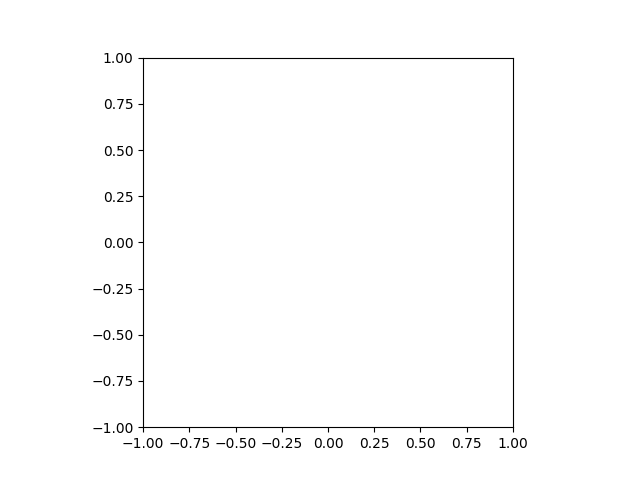

In [2]:
NUM_BODIES = 100
NUM_DIMS = 2
MASS_MIN = 1e7
MASS_MAX = 1e7
POSITION_MIN = -1.0
POSITION_MAX =  1.0
VELOCITY_MIN =  0
VELOCITY_MAX =  0
DELTA = 1e-2
NUM_ITERATIONS = 1000

sys = sys_rand(NUM_BODIES, MASS_MIN, MASS_MAX, POSITION_MIN, POSITION_MAX, VELOCITY_MIN, VELOCITY_MAX)
buf = System(NUM_BODIES, sys.m.copy(), sys.s.copy(), sys.v.copy(), sys.a.copy())

fig, ax = plt.subplots()

points, = ax.plot([], [], 'o', markersize=2)

ax.set_xlim(POSITION_MIN, POSITION_MAX)
ax.set_ylim(POSITION_MIN, POSITION_MAX)

frame_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def update(frame):
    global sys, buf
    sim_cpu_v02(sys, buf, DELTA)
    sys, buf = buf, sys

    x = sys.s[::2]
    y = sys.s[1::2]
    points.set_data(x, y)

    frame_text.set_text(f'Frame: {frame+1}')

    return points, frame_text

ani = FuncAnimation(fig, update, frames=None, interval=int(DELTA * 1000), blit=True)

plt.axis('scaled')
plt.show()

[ 0.          0.33352411  0.         -0.66704822]


/tmp/ipykernel_1624701/2921917901.py:34: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, frames=None, interval=int(DELTA * 1000), blit=True)


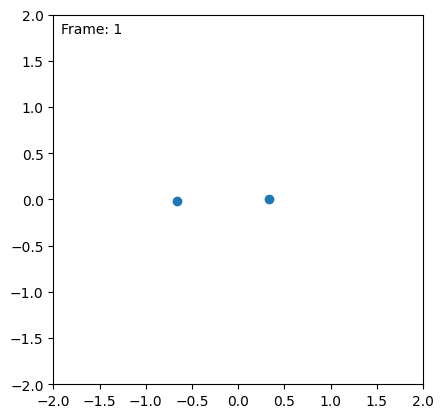

In [4]:
MASS_0 = 1e10
MASS_1 = 5e9
DISTANCE = 1.0
DELTA = 1e-2
NUM_ITERATIONS = 1000

sys = sys_waltz(MASS_0, MASS_1, DISTANCE)
buf = System(2, sys.m.copy(), sys.s.copy(), sys.v.copy(), sys.a.copy())

print(sys.v)

fig, ax = plt.subplots()

points, = ax.plot([], [], 'o')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

frame_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def update(frame):
    global sys, buf
    sim_cpu_v02(sys, buf, DELTA)
    sys, buf = buf, sys

    x = sys.s[::2]
    y = sys.s[1::2]
    points.set_data(x, y)

    frame_text.set_text(f'Frame: {frame+1}')

    return points, frame_text

ani = FuncAnimation(fig, update, frames=None, interval=int(DELTA * 1000), blit=True)

plt.axis('scaled')
plt.show()

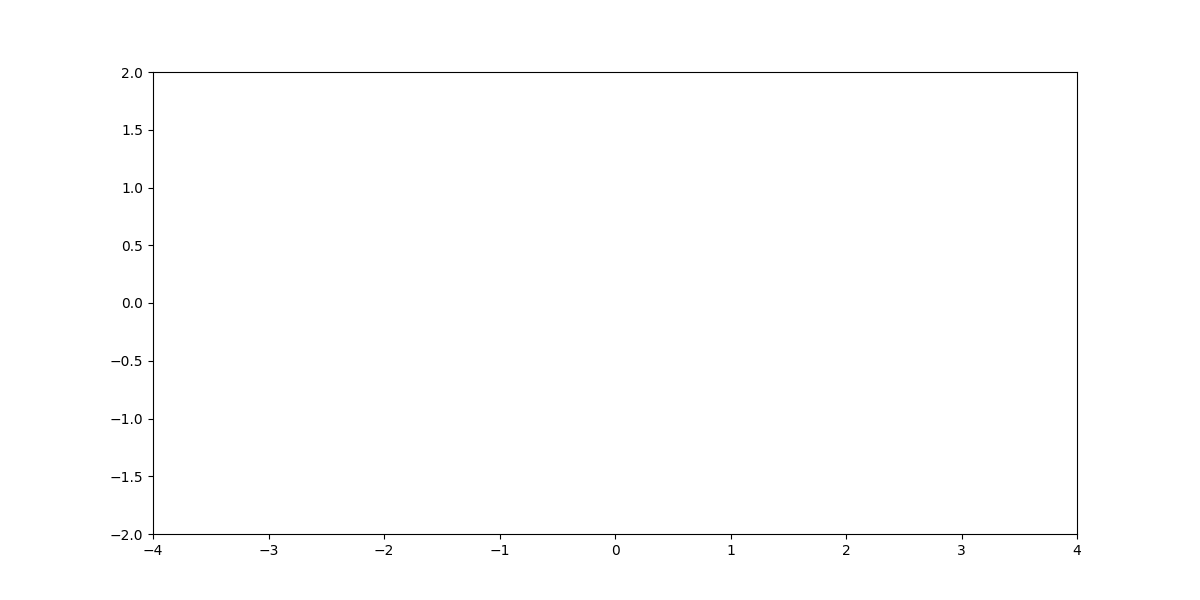

In [1]:
from lib import System
from lib import sys_rand
from lib import sys_waltz
from lib import sim_cpu_v00
from lib import sim_cpu_v01
from lib import sim_cpu_v02
from lib import sim_cpu_v03

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib widget

NUM_BODIES = 1000
MASS = 1e6
MASS_MIN = 1e6
MASS_MAX = 1e6
POSITION_RANGE = (-1, 1)
POSITION_MIN = -1.0
POSITION_MAX =  1.0
DISK_SCALE = 0.5
BULGE_SCALE = 0.05
VELOCITY_SCALE = 0.05
DELTA = 1e-2
ANGULAR_VELOCITY_SCALE = 0.3

# Generate initial positions
theta = np.random.uniform(0, 2 * np.pi, NUM_BODIES)
r_disk = np.random.exponential(scale=DISK_SCALE, size=NUM_BODIES // 2)
r_bulge = np.random.exponential(scale=BULGE_SCALE, size=NUM_BODIES - (NUM_BODIES // 2))

x_disk = r_disk * np.cos(theta[:NUM_BODIES // 2])
y_disk = r_disk * np.sin(theta[:NUM_BODIES // 2])
x_bulge = r_bulge * np.cos(theta[NUM_BODIES // 2:])
y_bulge = r_bulge * np.sin(theta[NUM_BODIES // 2:])

x = np.hstack([x_disk, x_bulge])
y = np.hstack([y_disk, y_bulge])

positions_1 = np.column_stack([x - 2, y + 0.0])
positions_2 = np.column_stack([x + 2, y - 0.0])
positions = np.empty((NUM_BODIES * 2, 2), dtype=np.float64)
positions[:NUM_BODIES, :] = positions_1
positions[NUM_BODIES:, :] = positions_2

# Generate initial velocities with rotation
r = np.sqrt(x**2 + y**2)
angular_velocity = ANGULAR_VELOCITY_SCALE / (r + 0.1)  # Adding a small constant to avoid division by zero
vx = -y * angular_velocity
vy = x * angular_velocity

velocities_1 = np.column_stack([vx + 0.5, vy])
velocities_2 = np.column_stack([vx - 0.5, vy])
velocities = np.empty((NUM_BODIES * 2, 2), dtype=np.float64)
velocities[:NUM_BODIES, :] = velocities_1
velocities[NUM_BODIES:, :] = velocities_2

# Set masses
masses = np.full(NUM_BODIES * 2, MASS)

sys = System(
    NUM_BODIES * 2,
    masses,
    np.copy(positions.flatten()),
    np.copy(velocities.flatten()),
    np.empty_like(positions.flatten()),
)
buf = System(NUM_BODIES * 2, sys.m.copy(), sys.s.copy(), sys.v.copy(), sys.a.copy())

fig, ax = plt.subplots(figsize=(12, 6))

points, = ax.plot([], [], 'o', markersize=1)

ax.set_xlim(POSITION_MIN * 4, POSITION_MAX * 4)
ax.set_ylim(POSITION_MIN * 2, POSITION_MAX * 2)

frame_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def update(frame):
    global sys, buf
    sim_cpu_v02(sys, buf, DELTA)
    sys, buf = buf, sys

    x_ = sys.s[::2]
    y_ = sys.s[1::2]
    points.set_data(x_, y_)

    frame_text.set_text(f'Frame: {frame+1}')

    return points, frame_text

ani = FuncAnimation(fig, update, frames=1000, interval=int(DELTA * 1000), blit=True, repeat=False)

plt.axis('scaled')
plt.show()
 
writergif = PillowWriter(fps=30) 
ani.save('galaxy_collision.gif', writer=writergif)
